In [84]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [67]:
TrainPath = '/Users/michael/Documents/DAAN570/Group Project/Group Project Images/Training'
ValPath = '/Users/michael/Documents/DAAN570/Group Project/Group Project Images/Validation'

In [242]:
datagen_train = keras.preprocessing.image.ImageDataGenerator(
    rescale =1./255,
    validation_split=.2,
    rotation_range=20,
    width_shift_range=.2,
    height_shift_range=.2,
    shear_range=.2,
    zoom_range=.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

datagen_val = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
)

batch_size=64

train_generator = datagen_train.flow_from_directory(
    TrainPath,
    seed=39,
    target_size=(224,224),
    batch_size=batch_size,
    classes=['female','male'],
    class_mode='binary',
    shuffle=True
)

val_generator = datagen_train.flow_from_directory(
    ValPath,
    seed=39,
    target_size=(224,224),
    batch_size=batch_size,
    classes=['female','male'],
    class_mode='binary',
    shuffle=True,
)

Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


In [243]:
from matplotlib.image import imread

takeapeak = imread('/Users/michael/Documents/DAAN570/Group Project/Group Project Images/Training/female/131422.jpg.jpg'
)
takeapeak.shape

(114, 92, 3)

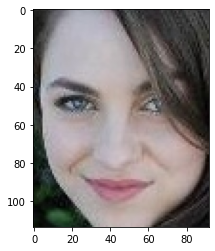

In [23]:
plt.imshow(takeapeak)

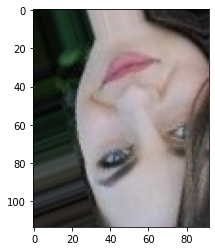

In [24]:
plt.imshow(datagen_train.random_transform(takeapeak))

In [244]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout, concatenate

In [245]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  # Input: 
  # - f1: number of filters of the 1x1 convolutional layer in the first path
  # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
  # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
  # - f4: number of filters of the 1x1 convolutional layer in the fourth path

  # 1st path:
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

  # 2nd path
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

  # 3rd path
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

  # 4th path
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

  output_layer = concatenate([path1, path2, path3, path4], axis = -1)

  return output_layer

In [246]:
def GoogLeNet():
  # input layer 
  input_layer = Input(shape = (224, 224, 3))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(1, activation = 'sigmoid')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(1, activation = 'sigmoid')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(1, activation = 'sigmoid')(X)
  
  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model


In [247]:
model = GoogLeNet()

In [248]:
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_23 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1180 (Conv2D)           (None, 109, 109, 64  9472        ['input_23[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_260 (MaxPooling2  (None, 54, 54, 64)  0           ['conv2d_1180[0][0]']            
 D)                                                                                       

                                                                                                  
 conv2d_1205 (Conv2D)           (None, 12, 12, 24)   12312       ['concatenate_182[0][0]']        
                                                                                                  
 max_pooling2d_266 (MaxPooling2  (None, 12, 12, 512)  0          ['concatenate_182[0][0]']        
 D)                                                                                               
                                                                                                  
 conv2d_1202 (Conv2D)           (None, 12, 12, 160)  82080       ['concatenate_182[0][0]']        
                                                                                                  
 conv2d_1204 (Conv2D)           (None, 12, 12, 224)  226016      ['conv2d_1203[0][0]']            
                                                                                                  
 conv2d_12

                                                                                                  
 conv2d_1230 (Conv2D)           (None, 5, 5, 32)     26656       ['max_pooling2d_270[0][0]']      
                                                                                                  
 max_pooling2d_271 (MaxPooling2  (None, 5, 5, 832)   0           ['max_pooling2d_270[0][0]']      
 D)                                                                                               
                                                                                                  
 conv2d_1227 (Conv2D)           (None, 5, 5, 256)    213248      ['max_pooling2d_270[0][0]']      
                                                                                                  
 conv2d_1229 (Conv2D)           (None, 5, 5, 320)    461120      ['conv2d_1228[0][0]']            
                                                                                                  
 conv2d_12

In [251]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

In [261]:
history = model.fit(train_generator, validation_data=val_generator, validation_steps = val_generator.samples // batch_size,
                   epochs=20,
                   steps_per_epoch = train_generator.samples // batch_size)

Epoch 1/20
734/734 [==============================] - 868s 1s/step - loss: 1.7114 - dense_105_loss: 0.5389 - dense_102_loss: 0.6273 - dense_104_loss: 0.5451 - dense_105_accuracy: 0.7290 - dense_102_accuracy: 0.6598 - dense_104_accuracy: 0.7266 - val_loss: 1.5705 - val_dense_105_loss: 0.4734 - val_dense_102_loss: 0.6079 - val_dense_104_loss: 0.4891 - val_dense_105_accuracy: 0.7802 - val_dense_102_accuracy: 0.6935 - val_dense_104_accuracy: 0.7696
Epoch 2/20
734/734 [==============================] - 925s 1s/step - loss: 1.5302 - dense_105_loss: 0.4594 - dense_102_loss: 0.6012 - dense_104_loss: 0.4696 - dense_105_accuracy: 0.7862 - dense_102_accuracy: 0.6900 - dense_104_accuracy: 0.7819 - val_loss: 1.4113 - val_dense_105_loss: 0.4174 - val_dense_102_loss: 0.5765 - val_dense_104_loss: 0.4174 - val_dense_105_accuracy: 0.8125 - val_dense_102_accuracy: 0.7222 - val_dense_104_accuracy: 0.8220
Epoch 3/20
734/734 [==============================] - 978s 1s/step - loss: 1.3637 - dense_105_loss: 0.

734/734 [==============================] - 953s 1s/step - loss: 0.6871 - dense_105_loss: 0.2023 - dense_102_loss: 0.2728 - dense_104_loss: 0.2120 - dense_105_accuracy: 0.9224 - dense_102_accuracy: 0.8915 - dense_104_accuracy: 0.9190 - val_loss: 0.6524 - val_dense_105_loss: 0.1957 - val_dense_102_loss: 0.2566 - val_dense_104_loss: 0.2001 - val_dense_105_accuracy: 0.9204 - val_dense_102_accuracy: 0.8978 - val_dense_104_accuracy: 0.9202
Epoch 20/20
734/734 [==============================] - 954s 1s/step - loss: 0.6864 - dense_105_loss: 0.2024 - dense_102_loss: 0.2720 - dense_104_loss: 0.2119 - dense_105_accuracy: 0.9218 - dense_102_accuracy: 0.8921 - dense_104_accuracy: 0.9191 - val_loss: 0.6313 - val_dense_105_loss: 0.1868 - val_dense_102_loss: 0.2500 - val_dense_104_loss: 0.1945 - val_dense_105_accuracy: 0.9312 - val_dense_102_accuracy: 0.9062 - val_dense_104_accuracy: 0.9268


In [264]:
def GoogLeNet2():
  # input layer 
  input_layer = Input(shape = (224, 224, 1))

  # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # convolutional layer: filters = 64, strides = 1
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

  # convolutional layer: filters = 192, kernel_size = (3,3)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 1st Inception block
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

  # 2nd Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

  # 3rd Inception block
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(1, activation = 'sigmoid')(X1)

  
  # 4th Inception block
  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 5th Inception block
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

  # 6th Inception block
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(1, activation = 'sigmoid')(X2)
  
  
  # 7th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

  # max-pooling layer: pool_size = (3,3), strides = 2
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

  # 8th Inception block
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

  # 9th Inception block
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

  # Global Average pooling layer 
  X = GlobalAveragePooling2D(name = 'GAPL')(X)

  # Dropoutlayer 
  X = Dropout(0.4)(X)

  # output layer 
  X = Dense(1, activation = 'sigmoid')(X)
  
  # model
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [265]:
model2 = GoogLeNet2()

In [266]:
model2.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_24 (InputLayer)          [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_1239 (Conv2D)           (None, 109, 109, 64  3200        ['input_24[0][0]']               
                                )                                                                 
                                                                                                  
 max_pooling2d_273 (MaxPooling2  (None, 54, 54, 64)  0           ['conv2d_1239[0][0]']            
 D)                                                                                       

                                                                                                  
 conv2d_1264 (Conv2D)           (None, 12, 12, 24)   12312       ['concatenate_191[0][0]']        
                                                                                                  
 max_pooling2d_279 (MaxPooling2  (None, 12, 12, 512)  0          ['concatenate_191[0][0]']        
 D)                                                                                               
                                                                                                  
 conv2d_1261 (Conv2D)           (None, 12, 12, 160)  82080       ['concatenate_191[0][0]']        
                                                                                                  
 conv2d_1263 (Conv2D)           (None, 12, 12, 224)  226016      ['conv2d_1262[0][0]']            
                                                                                                  
 conv2d_12

                                                                                                  
 conv2d_1289 (Conv2D)           (None, 5, 5, 32)     26656       ['max_pooling2d_283[0][0]']      
                                                                                                  
 max_pooling2d_284 (MaxPooling2  (None, 5, 5, 832)   0           ['max_pooling2d_283[0][0]']      
 D)                                                                                               
                                                                                                  
 conv2d_1286 (Conv2D)           (None, 5, 5, 256)    213248      ['max_pooling2d_283[0][0]']      
                                                                                                  
 conv2d_1288 (Conv2D)           (None, 5, 5, 320)    461120      ['conv2d_1287[0][0]']            
                                                                                                  
 conv2d_12

In [270]:

train_generator_gray = datagen_train.flow_from_directory(
    TrainPath,
    seed=39,
    target_size=(224,224),
    color_mode='grayscale',
    batch_size=batch_size,
    classes=['female','male'],
    class_mode='binary',
    shuffle=True
)

val_generator_gray = datagen_train.flow_from_directory(
    ValPath,
    seed=39,
    target_size=(224,224),
    color_mode='grayscale',
    batch_size=batch_size,
    classes=['female','male'],
    class_mode='binary',
    shuffle=True,
)

Found 47009 images belonging to 2 classes.
Found 11649 images belonging to 2 classes.


In [271]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy'])

In [273]:
history2 = model2.fit(train_generator_gray, validation_data=val_generator_gray, validation_steps = val_generator_gray.samples // batch_size,
                   epochs=20,
                   steps_per_epoch = train_generator_gray.samples // batch_size)

Epoch 1/20
734/734 [==============================] - 809s 1s/step - loss: 1.7534 - dense_110_loss: 0.5495 - dense_107_loss: 0.6460 - dense_109_loss: 0.5579 - dense_110_accuracy: 0.7198 - dense_107_accuracy: 0.6391 - dense_109_accuracy: 0.7161 - val_loss: 1.6585 - val_dense_110_loss: 0.5086 - val_dense_107_loss: 0.6281 - val_dense_109_loss: 0.5218 - val_dense_110_accuracy: 0.7519 - val_dense_107_accuracy: 0.6750 - val_dense_109_accuracy: 0.7405
Epoch 2/20
734/734 [==============================] - 849s 1s/step - loss: 1.5799 - dense_110_loss: 0.4784 - dense_107_loss: 0.6104 - dense_109_loss: 0.4911 - dense_110_accuracy: 0.7755 - dense_107_accuracy: 0.6889 - dense_109_accuracy: 0.7678 - val_loss: 1.4604 - val_dense_110_loss: 0.4294 - val_dense_107_loss: 0.5844 - val_dense_109_loss: 0.4467 - val_dense_110_accuracy: 0.8069 - val_dense_107_accuracy: 0.7200 - val_dense_109_accuracy: 0.7945
Epoch 3/20
734/734 [==============================] - 899s 1s/step - loss: 1.4213 - dense_110_loss: 0.

734/734 [==============================] - 901s 1s/step - loss: 0.7984 - dense_110_loss: 0.2302 - dense_107_loss: 0.3285 - dense_109_loss: 0.2396 - dense_110_accuracy: 0.9100 - dense_107_accuracy: 0.8651 - dense_109_accuracy: 0.9064 - val_loss: 0.7366 - val_dense_110_loss: 0.2089 - val_dense_107_loss: 0.3136 - val_dense_109_loss: 0.2141 - val_dense_110_accuracy: 0.9192 - val_dense_107_accuracy: 0.8758 - val_dense_109_accuracy: 0.9190
Epoch 20/20
734/734 [==============================] - 904s 1s/step - loss: 0.7974 - dense_110_loss: 0.2301 - dense_107_loss: 0.3274 - dense_109_loss: 0.2399 - dense_110_accuracy: 0.9099 - dense_107_accuracy: 0.8650 - dense_109_accuracy: 0.9066 - val_loss: 0.7133 - val_dense_110_loss: 0.2036 - val_dense_107_loss: 0.2998 - val_dense_109_loss: 0.2099 - val_dense_110_accuracy: 0.9210 - val_dense_107_accuracy: 0.8829 - val_dense_109_accuracy: 0.9190


In [213]:
from tqdm.notebook import tqdm
import os

In [214]:
BASE_DIR = '/Users/michael/Documents/DAAN570/Group Project/UTKFace/utkface_aligned_cropped/UTKFace'

In [215]:
# labels - age, gender, ethnicity
image_paths = []
age_labels = []
gender_labels = []

for filename in tqdm(os.listdir(BASE_DIR)):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [216]:
#Visualize data by pandas
image_paths = pd.Series(list(image_paths), name = 'Images Path')
age_labels = pd.Series(list(age_labels), name = 'Ages')
gender_labels = pd.Series(list(gender_labels), name = 'Genders')

UTKdataframe = pd.concat([image_paths, age_labels, gender_labels], axis = 1)
UTKdataframe

,Images Path,Ages,Genders
0,/Users/michael/Documents/DAAN570/Group Project...,9,1
1,/Users/michael/Documents/DAAN570/Group Project...,36,0
2,/Users/michael/Documents/DAAN570/Group Project...,86,1
3,/Users/michael/Documents/DAAN570/Group Project...,26,1
4,/Users/michael/Documents/DAAN570/Group Project...,1,1
...,...,...,...
23703,/Users/michael/Documents/DAAN570/Group Project...,35,0
23704,/Users/michael/Documents/DAAN570/Group Project...,52,0
23705,/Users/michael/Documents/DAAN570/Group Project...,26,0
23706,/Users/michael/Documents/DAAN570/Group Project...,28,0


In [217]:
UTKdataframe['Genders'] = np.logical_not(UTKdataframe['Genders']).astype(int)
UTKdataframe

,Images Path,Ages,Genders
0,/Users/michael/Documents/DAAN570/Group Project...,9,0
1,/Users/michael/Documents/DAAN570/Group Project...,36,1
2,/Users/michael/Documents/DAAN570/Group Project...,86,0
3,/Users/michael/Documents/DAAN570/Group Project...,26,0
4,/Users/michael/Documents/DAAN570/Group Project...,1,0
...,...,...,...
23703,/Users/michael/Documents/DAAN570/Group Project...,35,1
23704,/Users/michael/Documents/DAAN570/Group Project...,52,1
23705,/Users/michael/Documents/DAAN570/Group Project...,26,1
23706,/Users/michael/Documents/DAAN570/Group Project...,28,1


In [218]:
gender_dict = {0:'female', 1:'male'}

In [219]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

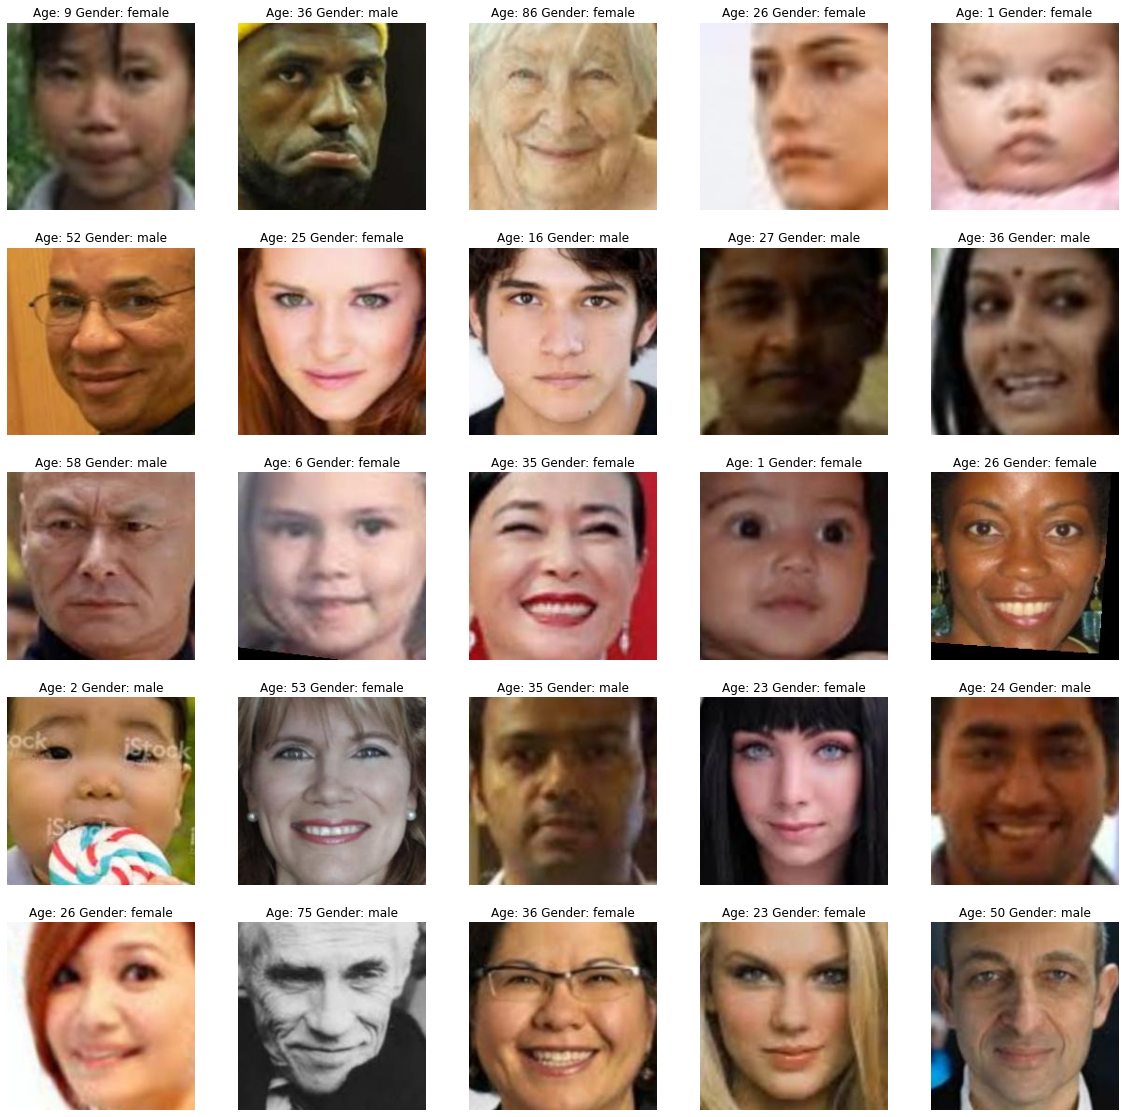

In [220]:
plt.figure(figsize=(20, 20))
files = UTKdataframe.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
    plt.axis('off')

In [221]:
from tqdm import tqdm
from PIL import Image, ImageOps

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=False)
        img = img.resize((224, 224), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    # ignore this step if using RGB
    #features = features.reshape(len(features), 128, 128, 3)
    return features

In [222]:
X = extract_features(UTKdataframe['Images Path'])

  0%|          | 0/23708 [00:00<?, ?it/s]<ipython-input-221-5230771b39d0>:8: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)
100%|██████████| 23708/23708 [00:30<00:00, 783.11it/s]


In [253]:
X.shape

(23708, 224, 224, 3)

In [254]:
y_gender = np.array(UTKdataframe['Genders'])
y_gender = np.asarray(y_gender).astype('float32').reshape((-1,1))

In [255]:
y_gender.shape

(23708, 1)

In [295]:
RGBUTKscore = model.evaluate(X, y_gender, verbose=0)

In [296]:
RGBUTKscore

[194.41270446777344,
 54.86495590209961,
 75.04700469970703,
 64.5006332397461,
 0.8051290512084961,
 0.7825628519058228,
 0.8005736470222473]

In [288]:
def grayscale_extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((224, 224), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    
    features = features.reshape(len(features), 224, 224, 1)
    return features

In [289]:
X2 = grayscale_extract_features(UTKdataframe['Images Path'])

  0%|          | 0/23708 [00:00<?, ?it/s]<ipython-input-288-7cc72125b02c>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((224, 224), Image.ANTIALIAS)
100%|██████████| 23708/23708 [00:16<00:00, 1401.04it/s]


In [290]:
X2.shape

(23708, 224, 224, 1)

In [293]:
GSUTKscore = model2.evaluate(X2, y_gender, verbose=0)

In [294]:
GSUTKscore

[370.6414489746094,
 70.8994140625,
 192.9474639892578,
 106.79460144042969,
 0.6186097264289856,
 0.552682638168335,
 0.5830099582672119]